# Introduction

- The code in this python jupyter notebook is to be used jointly with a GeoSpock DB Discovery deployment for which you can sign up [here](https://geospock.com/en/product/geospock-db-discovery/). 
- GeoSpock DB Discovery provides a way to experience the power of GeoSpock DB without having to pay any license fees. Typically available for a short trial period, GeoSpock DB Discovery gives you control of your own query engine and allows you to run queries using standard ANSI SQL against a range of pre-selected datasets.
- It is recommended to execute the following code using a cluster of no less than 10 nodes.
- Finally, further documentation on GeoSpock DB Discovery and geospatial queries can be found [here](https://docs.geospock.com/discovery/about/).

# Case Study: Road Traffic Accident investigation in Singapore

As an example of using the GeoSpock platform in a potentially real life scenario, where you will assume the role of an accident investigator that is looking to understand to understand a road accident. 

We first of all load some libraries, define a few helpful functions, and set up a connection to the database, before launching the investigation.

### Import libraries

In [1]:
import prestodb
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
pd.set_option('display.max_columns',500)

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

import matplotlib.ticker as ticker
from matplotlib.ticker import FormatStrFormatter

import keplergl
import json

import datetime

from os.path import expanduser

## Auxiliary Functions

In [2]:
def getcolnames(cnn,tbl):
    cur=cnn.cursor()
    querycolumnnames="SHOW COLUMNS FROM geospock.default."+tbl
    cur.execute(querycolumnnames)
    cols=cur.fetchall()
    colnames = [col[0] for col in cols]
    cur.close()
    return colnames

In [3]:
def showtables(cnn):
    cur=cnn.cursor()
    querycolumnnames='SHOW TABLES FROM geospock.default'
    cur.execute(querycolumnnames)
    cols=cur.fetchall()
    colnames = [col[0] for col in cols]
    cur.close()
    return colnames

In [4]:
def getschemas(cnn):
    cur=cnn.cursor()
    querycolumnnames='SHOW SCHEMAS FROM geospock'
    cur.execute(querycolumnnames)
    cols=cur.fetchall()
    colnames = [col[0] for col in cols]
    cur.close()
    return colnames

In [5]:
def runquery(cnn,cls,querytext):
    sttime = datetime.datetime.now()
    print("Starting query at: "+str(sttime)+".....")
    cur = cnn.cursor()
    cur.execute(querytext)
    rows = cur.fetchall()
    cur.close()
    endtime = datetime.datetime.now()
    print("Finished query at: "+str(endtime)+".")
    tdelt=(endtime-sttime).seconds
    print("Query duration: "+str(tdelt)+" seconds.")
    print("Rows returned: "+str(len(rows)))
    return pd.DataFrame(rows,columns=cls)

In [6]:
def runqueryvanilla(cnn,querytext):
    cur = cnn.cursor()
    cur.execute(querytext)
    rows = cur.fetchall()
    cur.close()
    return rows

In [7]:
def load_kepler_config(config_filename):
    with open(config_filename, 'r') as f:
        config = json.load(f)
    print(config_filename, 'opened')        
    return config

In [8]:
def save_kepler_config(config, config_filename, write_kepler):
    if write_kepler:
        with open(config_filename, 'w') as f:
            json.dump(config, f)
        print(config_filename, 'saved')
    else:
        print(config_filename, 'NOT saved')

In [9]:
def create_dir(dirName):
    if not os.path.exists(dirName):
        os.mkdir(dirName)
        print("Directory " , dirName ,  " Created ")
    else:    
        print("Directory " , dirName ,  " already exists")

In [10]:
def makeconn(hstb,uname,pswd, authentication):
    if authentication == 'HTTP':
        return prestodb.dbapi.connect(
            host=hstb,
            port=80,
            user=uname.strip(),
            catalog='geospock',
            schema='default',
            http_scheme='http'
            )
    elif authentication == 'HTTPs':
        return prestodb.dbapi.connect(
        host=hstb,
        port=443,
        user=uname.strip(),
        catalog='geospock',
        schema='default',
        http_scheme='https',    
        auth=prestodb.auth.BasicAuthentication(uname.strip(), pswd.strip())
        )
    else:
        print('Aunthentication method not valid')

# Specify Authentication Methods

### HTTP authentication method
### If you are NOT using the SSL option in the Cloudformation script the following parameters are used in the connection functions below.
- host = assign real value, e.g. `disco-Prest-26Z2LD7S11IPM-2177915702.ap-southeast-1.elb.amazonaws.com`
- port = 80
- username = 'username' 
- password = ''
- http_scheme = 'http'
- commented #auth=prestodb.auth.BasicAuthentication(uname.strip(), pswd.strip())

### HTTPS authentication method
### If you ARE using the SSL option in the Cloudformation script the following parameters are used in the connection functions below.
- host = assign its real value e.g. `discovery.companyname.com`
- port = 443
- username = 'username' 
- password = ''
- http_scheme = 'https'
- auth=prestodb.auth.BasicAuthentication(uname.strip(), pswd.strip())

In [11]:
# Remember to change GeoSpockDBDiscoveryHostname for its respective value
# e.g disco-Prest-26Z2LD7S11IPM-2177915702.ap-southeast-1.elb.amazonaws.com 
# or discovery.companyname.com 
# depending if HTTP or HTTPS is to be used
# username and password are to be left with these default values
host            = """GeoSpockDBDiscoveryHostname"""
username       = 'username'
password       = ''
authentication = '' # HTTP or HTTPS
newconn        = makeconn(host, username, password,authentication)

Aunthentication method not valid


### Specify if to download data to local or modify Kepler configuration

In [12]:
write_data   = True
write_kepler = False

In [13]:
create_dir("local_data")

Directory  local_data  already exists


# Case Study: Accident investigation in Singapore

A **traffic accident occurred on 30th August, 2019**, which is of interest to various authorities.
   
An investigator has asked for our help in examining the accidents data from that date, with a view to identifying the accident, and the behavior of vehicles associated with it.

We first get a list of all the accidents on a particular day, from **764,839 yearly incidents**. This query takes advantage of timestamp indexing:

## Q1: Accidents on 30-08-2019

In [14]:
QUERY_accidents_on_date="""
SELECT event.*
  FROM geospock.default.sg_traffic_incidents AS event 
 WHERE event.timestamp BETWEEN TIMESTAMP '2019-08-30 00:00:00' AND TIMESTAMP '2019-08-31 00:00:00' 
   AND event.type IN ('Accident')
"""

In [15]:
accidentv3cols  = ['latitude', 'longitude', 'month_timestamp', 'message', 'type',  'timestamp']
# Run query live
accidentsondate = runquery(newconn, accidentv3cols,QUERY_accidents_on_date)\
                  .drop_duplicates(subset=['latitude', 'longitude' ,'timestamp'])\
                  .sort_values("timestamp").reset_index().drop("index",axis=1)

Starting query at: 2020-10-03 18:37:22.749427.....
Finished query at: 2020-10-03 18:37:25.105932.
Query duration: 2 seconds.
Rows returned: 140


In [16]:
# Read or write DF locally
if write_data:
    accidentsondate.to_csv("local_data/accidentsondateDF.csv",header=True,index=False)
# accidentsondate=pd.read_csv("local_data/accidentsondateDF.csv")

How many road accidents occurred on the day in question?

In [17]:
len(accidentsondate)

46

In [18]:
accidentsondate.loc[29:34,:]

,latitude,longitude,month_timestamp,message,type,timestamp
29,1.329156,103.855434,2019-08-01 00:00:00.000,(30/8)16:15 Accident on PIE (towards Changi Ai...,Accident,2019-08-30 16:15:00.000
30,1.279022,103.857211,2019-08-01 00:00:00.000,(30/8)17:23 Accident on Bayfront Avenue near B...,Accident,2019-08-30 17:23:00.000
31,1.365551,103.953212,2019-08-01 00:00:00.000,(30/8)17:51 Accident on TPE (towards SLE) afte...,Accident,2019-08-30 17:51:00.000
32,1.389820,103.761085,2019-08-01 00:00:00.000,(30/8)17:55 Accident on KJE (towards BKE) afte...,Accident,2019-08-30 17:55:00.000
33,1.316207,103.758745,2019-08-01 00:00:00.000,(30/8)18:40 Accident on AYE (towards MCE) befo...,Accident,2019-08-30 18:40:00.000
34,1.333915,103.978025,2019-08-01 00:00:00.000,(30/8)18:43 Accident on ECP (towards Changi Ai...,Accident,2019-08-30 18:43:00.000


We see that there are  **46 accidents on the day of interest**.

The investigator informs us that **the accident occurring at 17:51 near the airport** is the one of particular interest. The speed camera locations are potential sources of key information so we also query this dataset to examine alongside the accidents data. 

## Q2: Speed camera locations

Furthermore, we look for the speed cameras in the vicinity of the accident:

In [19]:
speedcameracols            = ['lat', 'long', 'name']
QUERY_speedcameralocations = "SELECT * FROM geospock.default.sg_speed_laser_camera"
# Run query live
speedcameralocations       = runquery(newconn, speedcameracols,QUERY_speedcameralocations)

Starting query at: 2020-10-03 18:37:25.304801.....
Finished query at: 2020-10-03 18:37:26.694597.
Query duration: 1 seconds.
Rows returned: 48


In [20]:
# Read or write DF locally
if write_data:
     speedcameralocations.to_csv("local_data/speedcameralocationsDF.csv",header=True,index=False)
# speedcameralocations=pd.read_csv("local_data/speedcameralocationsDF.csv")

In [21]:
w3b = keplergl.KeplerGl(height=500)
w3b.add_data(data=accidentsondate,name="Accidents")
w3b.add_data(data=accidentsondate.loc[31,:].to_frame().transpose(),name="MainAccident")
w3b.add_data(data=speedcameralocations,name="SpeedCameras")

User Guide: https://github.com/keplergl/kepler.gl/blob/master/docs/keplergl-jupyter/user-guide.md


In [22]:
#Read widget config
config_filename_w3b = 'kepler_config/config_w3b_accidentlocsSpeedCams-Singapore-Kepler_exec.json'
w3b.config          = load_kepler_config(config_filename_w3b)

kepler_config/config_w3b_accidentlocsSpeedCams-Singapore-Kepler_exec.json opened


In [23]:
w3b

KeplerGl(config={'version': 'v1', 'config': {'visState': {'filters': [], 'layers': [{'id': 'd4yqoo', 'type': '…

In [24]:
#Write widget config
save_kepler_config(w3b.config, config_filename_w3b, write_kepler)

kepler_config/config_w3b_accidentlocsSpeedCams-Singapore-Kepler_exec.json saved


This allows us to notice that there were **no speed cameras near the accident**. 

However, we can query the dataset to **discover the vehicles which were within 2.5m of the accident location during the 30s preceding the accident**. 

This query is **performed on a table containing 1.3 trillion rows**.

## Q3: Query vehicles near accident

The following query will return the vehicles that were within 2.5m of the accident location during the 30s preceding the accident. This allows us
to find out what vehicles were in the vicinity of the accident. This query takes advantage of the geotemporal indexing by accessing a historical localized snapshot.

This query is performed on a table containing 1.3 Trillion rows.

In [25]:
QUERY_vehiclesnearaccident = """
SELECT DISTINCT(vehicles.erp_vehicle_id) as vehicleid 
  FROM geospock.default.sg_erp2_synthesis AS vehicles 
 WHERE vehicles.longitude BETWEEN 103.950711575 AND 103.955711575 
   AND vehicles.latitude BETWEEN 1.36305117308 AND 1.36805117308 
   AND (vehicles.timestamp BETWEEN TIMESTAMP '2019-08-30 17:51:00' - INTERVAL '30' SECOND AND TIMESTAMP '2019-08-30 17:51:00' )
"""    

In [26]:
# Run query live
vehiclesnearaccident = runquery(newconn,["VehicleID"],QUERY_vehiclesnearaccident)

Starting query at: 2020-10-03 18:37:27.126697.....
Finished query at: 2020-10-03 18:37:31.195969.
Query duration: 4 seconds.
Rows returned: 106


In [27]:
# Read or write DF locally
if write_data:
     vehiclesnearaccident.to_csv("local_data/vehiclesnearaccidentDF.csv",header=True,index=False)
# vehiclesnearaccident=pd.read_csv("local_data/vehiclesnearaccidentDF.csv")

We can see that 106 vehicles were located within 2.5m of the accident during the 30s beforehand.

How about their IDs?

In [28]:
vehiclesnearaccident.head(10)

,VehicleID
0,136c86277d447a93afae7755c3cdb6e9
1,ee86c31efacbec92bbd3ee3426038ac9
2,fc758c401b0c1544257f212153c084cd
3,59fc1f50766688bbd136302488ebbc5c
4,4572d898acbb8cc392180909f2206296
5,3d36f2b86db15fa9f9381a599dadd60
6,f2163df9d643b04282e21126ed049a65
7,fbe04c7ff891b28d07801859e54cf203
8,3210378e173898db1d3aa43268d695b2
9,e06e01201312069c28ebcf199f0101f8


Having identified the **vehicles of interest**, we would like to know where these vehicles were travelling to and from on their **journeys**...

## Q4: Get vehicle trajectories

With the vehicles IDs we can find their trajectories using the following query that takes advantage of unique vehicle or fleet history by device ID set.

In [29]:
QUERY_ERPtrajectory_vehsnearaccident="""
SELECT erppoints.* 
  FROM geospock.default.sg_erp2_synthesis AS erppoints 
 WHERE erppoints.erp_vehicle_id IN """+str(tuple(vehiclesnearaccident.VehicleID))+"""
   AND erppoints.timestamp BETWEEN TIMESTAMP '2019-08-30 00:00:00' AND TIMESTAMP '2019-08-31 00:00:00'
"""

In [30]:
erpcols               = ['longitude', 'latitude', 'erp_vehicle_id', 'timestamp', 'erp_vehicle_types']
# Run query live
trajectories_accident = runquery(newconn,erpcols,QUERY_ERPtrajectory_vehsnearaccident)

Starting query at: 2020-10-03 18:37:31.221809.....
Finished query at: 2020-10-03 18:37:49.210550.
Query duration: 17 seconds.
Rows returned: 147921


In [31]:
# Read or write DF locally
if write_data:
    trajectories_accident.to_csv("local_data/trajectoriesaccidentDF.csv",header=True,index=False)
# trajectories_accident=pd.read_csv("local_data/trajectoriesaccidentDF.csv")

In [32]:
w4 = keplergl.KeplerGl(height=500)
w4.add_data(data=trajectories_accident,name="Trajectories")
w4.add_data(data=accidentsondate.loc[31,:].to_frame().transpose(),name="MainAccident")

User Guide: https://github.com/keplergl/kepler.gl/blob/master/docs/keplergl-jupyter/user-guide.md


In [33]:
#Read widget config
config_filename_w4 = 'kepler_config/config_w4_vehicleTracks-Singapore-Kepler.json'
w4.config          = load_kepler_config(config_filename_w4)

kepler_config/config_w4_vehicleTracks-Singapore-Kepler.json opened


In [34]:
w4

KeplerGl(config={'version': 'v1', 'config': {'visState': {'filters': [], 'layers': [{'id': 'gi5xauo', 'type': …

In [35]:
# Write widget config
save_kepler_config(w4.config, config_filename_w4, write_kepler)

kepler_config/config_w4_vehicleTracks-Singapore-Kepler.json saved


Furthermore, the investigator has a theory that **the accident may have involved a taxi driver**. 
In order to assist the inquiry, we query where any **taxis** which were in the vicinity of the accident were traveling to/from, and the route they took.

## Q5: Get taxi trajectories

The investigator can now identify which taxis were in the vicinity of the accident using unique vehicle or fleet history by device ID set and/or secondary field.

In [36]:
QUERY_ERPtrajectory_taxisnearaccident="""
SELECT erppoints.* 
  FROM geospock.default.sg_erp2_synthesis AS erppoints 
 WHERE erppoints.erp_vehicle_id IN """+str(tuple(vehiclesnearaccident.VehicleID))+"""
   AND erppoints.erp_vehicle_types IN ('Taxi') 
   AND erppoints.timestamp BETWEEN TIMESTAMP '2019-08-30 00:00:00' AND TIMESTAMP '2019-08-31 00:00:00'
"""

In [37]:
# Run query live
trajectories_taxis_accident=runquery(newconn,erpcols,QUERY_ERPtrajectory_taxisnearaccident)

Starting query at: 2020-10-03 18:37:55.467256.....
Finished query at: 2020-10-03 18:38:22.234358.
Query duration: 26 seconds.
Rows returned: 2023


In [38]:
# Read or write DF locally
if write_data:
    trajectories_taxis_accident.to_csv("local_data/trajectoriestaxisaccidentDF.csv",header=True,index=False)
# trajectories_taxis_accident=pd.read_csv("local_data/trajectoriestaxisaccidentDF.csv")

The investigator can now identify which taxis were in the vicinity of the accident:

In [39]:
trajectories_taxis_accident.erp_vehicle_id.unique()

array(['587200174ae46ad63551ccaff3588e11'], dtype=object)

... hence, it can be seen that **only one taxi** was passing through the accident location at the time of interest, and the investigator can easily see where it was going to and from:

In [40]:
w4b = keplergl.KeplerGl(height=500)
w4b.add_data(data=trajectories_taxis_accident,name="Taxi Trajectory")
w4b.add_data(data=accidentsondate.loc[31,:].to_frame().transpose(),name="MainAccident")

User Guide: https://github.com/keplergl/kepler.gl/blob/master/docs/keplergl-jupyter/user-guide.md


In [41]:
#Read widget config
config_filename_w4b ='kepler_config/config_w4b_taxiTrack-Singapore-Kepler.json'
w4b.config          = load_kepler_config(config_filename_w4b)    

kepler_config/config_w4b_taxiTrack-Singapore-Kepler.json opened


In [42]:
w4b

KeplerGl(config={'version': 'v1', 'config': {'visState': {'filters': [], 'layers': [{'id': 'qlxzaec', 'type': …

In [43]:
# Write widget config
save_kepler_config(w4b.config, config_filename_w4b, write_kepler)

kepler_config/config_w4b_taxiTrack-Singapore-Kepler.json saved


The investigator can now **make enquiries about this taxi and the driver!**

We see that **the accident took place at a busy time of day around the area of interest**, so it is possible that heavy traffic could have contributed to the accident.

## Q6: Individual vehicle analysis. All origins and destinations of one taxi over a month

The investigator now wishes to **delve further into the behavior of the particular taxi** identified as being associated with the accident. It is thought that the driver is involved in criminal activity!

 To assist the investigator, we can query **all the origins and destinations of the taxi over the period of interest (one month, in this case)**. 

In [44]:
QUERY_individualvehiclestartends= """
   SELECT 
          date_trunc('day',vehicles.timestamp) AS dayref, 
          min_by( vehicles.latitude , vehicles.timestamp )  AS startlat, 
          min_by( vehicles.longitude , vehicles.timestamp ) AS startlon, 
          max_by( vehicles.latitude , vehicles.timestamp ) AS endlat, 
          max_by( vehicles.longitude , vehicles.timestamp ) AS endlon, 
          min(vehicles.timestamp) as starttime, 
          max(vehicles.timestamp) as endtime 
     FROM geospock.default.sg_erp2_synthesis AS vehicles 
    WHERE vehicles.erp_vehicle_id IN ('587200174ae46ad63551ccaff3588e11') 
      AND vehicles.timestamp BETWEEN TIMESTAMP '2019-08-01 00:00:00' AND TIMESTAMP '2019-09-01 00:00:00'
GROUP BY 1 
ORDER BY 1
"""

In [45]:
# Run query live
individualvehiclestartends = runquery(newconn, ['Day','StartLat','StartLon','EndLat','EndLon','StartTime','EndTime'], QUERY_individualvehiclestartends)

Starting query at: 2020-10-03 18:38:22.416136.....
Finished query at: 2020-10-03 18:38:40.605291.
Query duration: 18 seconds.
Rows returned: 18


In [46]:
# Read or write DF locally
if write_data:
     individualvehiclestartends.to_csv("local_data/individualvehiclestartendsDF.csv",header=True,index=False)
# individualvehiclestartends=pd.read_csv("local_data/individualvehiclestartendsDF.csv")

In [47]:
w5 = keplergl.KeplerGl(height=500)
w5.add_data(data=individualvehiclestartends,name="Vehicle Journeys")
w5.add_data(data=accidentsondate.loc[31,:].to_frame().transpose(),name="MainAccident")

User Guide: https://github.com/keplergl/kepler.gl/blob/master/docs/keplergl-jupyter/user-guide.md


In [48]:
#Read widget config
config_filename_w5 = 'kepler_config/config_w5_taxistartends-Singapore-Kepler.json'
w5.config          = load_kepler_config(config_filename_w5)

kepler_config/config_w5_taxistartends-Singapore-Kepler.json opened


In [49]:
w5

KeplerGl(config={'version': 'v1', 'config': {'visState': {'filters': [], 'layers': [{'id': 'ccjhzy', 'type': '…

In [50]:
# #Write widget config
save_kepler_config(w5.config, config_filename_w5, write_kepler)

kepler_config/config_w5_taxistartends-Singapore-Kepler.json saved


From the graphics visualization it can be seen that the taxi hasn't made too many trips. Perhaps this is due to the fact that this taxi is a masquerade for other more nefarious activities. The investigator now has a few leads to explore thanks to the data analysis conducted. 

**Our job here is done!**

# Virtual ERP Gantry
Our accident investigator wishes to **understand whether heavy traffic may have contributed to the accident.**

We can assist by querying the counts per minute of distinct vehicle IDs within a defined radius of a gantry located near the accident site.

## Q7: Query all vehicles passing through a defined spatial window over a day grouped by minute

 The following query takes advantage of geotemporal indexing by using the data access pattern known as historical localized snapshot.

In [51]:
QUERY_vehiclecounts_gantry="""
  SELECT date_trunc('minute',erp.timestamp), COUNT(DISTINCT(erp.erp_vehicle_id)) 
    FROM geospock.default.sg_erp2_synthesis AS erp 
   WHERE erp.longitude BETWEEN 103.950711575 AND 103.955711575 
     AND erp.latitude BETWEEN 1.36305117308 AND 1.36805117308 
     AND timestamp BETWEEN TIMESTAMP '2019-08-30 00:00:00' AND TIMESTAMP '2019-08-31 00:00:00' 
GROUP BY 1 
ORDER BY 1
"""

In [52]:
# Run query live
gantrycountsdata=runquery(newconn,["Minute","Count"],QUERY_vehiclecounts_gantry)

Starting query at: 2020-10-03 18:38:40.659514.....
Finished query at: 2020-10-03 18:38:46.101455.
Query duration: 5 seconds.
Rows returned: 1440


In [53]:
# Read or write DF locally
if write_data:
    gantrycountsdata.to_csv("local_data/gantrycountsDF.csv",header=True,index=False)
# gantrycountsdata=pd.read_csv("local_data/gantrycountsDF.csv")

The vehicle counts of this virtual EPR gantry are shown in the figure below. From there it can be seen that the traffic around that area looks like what we would expect, with peaks at around 6:00-8:00 and then 16:00-19:00 due to rush hour traffic.

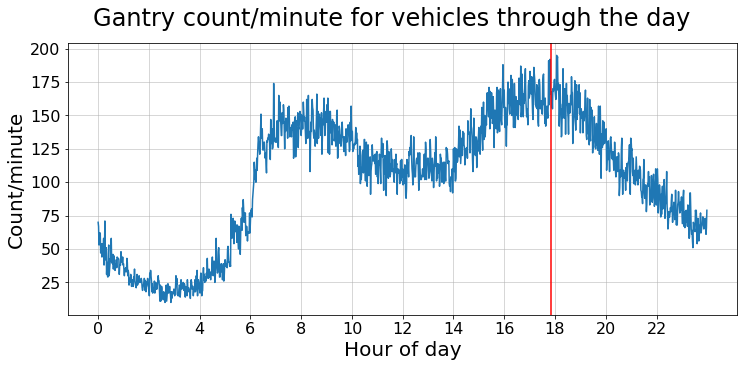

In [54]:
fig, axes = plt.subplots(nrows=1, ncols=1)
fig.suptitle('Gantry count/minute for vehicles through the day', fontsize=24)
gantrycountsdata.plot(ax=axes,legend=False,figsize=[12,5])
axes.set_ylabel("Count/minute",fontsize=20)
axes.set_xlabel("Hour of day",fontsize=20)
axes.grid(linestyle='-', linewidth='0.5')
axes.axvline(x=(60*17.83),color='r')
axes.set_xticks(np.arange(0, 24*60, step=120.0))
ticks_x = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/60))
axes.xaxis.set_major_formatter(ticks_x)
plt.setp(axes.get_xticklabels(),fontsize=16,rotation=0)
plt.setp(axes.get_yticklabels(),fontsize=16,rotation=0)
plt.show()
plt.close()

Moreover, to assess the effect that the accident had on traffic, the investigator wishes to **understand the traffic speeds in the vicinity of the accident.**

We thus **query the minimum traffic speeds within a few meters of the accident location** over the time period of the accident. This query uses the data access pattern spatial join of events vs. POIs.

## Q8: Speed bands in vicinity of accident

In [55]:
QUERY_speedbands_near_accident = """
SELECT speedbandtable.*
  FROM geospock.default.sg_speed_bands AS speedbandtable 
 WHERE (ST_Distance(ST_Point(speedbandtable.longitude1, speedbandtable.latitude1), ST_Point(103.95321157469873, 1.3655511730786898)) < 0.00025
   AND speedbandtable.timestamp BETWEEN TIMESTAMP '2019-08-30 15:00:00' AND TIMESTAMP '2019-08-31 00:00:00')
"""

In [56]:
speedbandcols          = ['linkid', 'timestamp', 'latitude1',\
                          'longitude1', 'roadname', 'roadcategory',\
                          'speedband', 'minimumspeed', 'maximumspeed', 'latitude2', 'longitude2']
# Run query live
speedbandsnearaccident = runquery(newconn,speedbandcols,QUERY_speedbands_near_accident)

Starting query at: 2020-10-03 18:38:46.324002.....
Finished query at: 2020-10-03 18:38:48.193574.
Query duration: 1 seconds.
Rows returned: 76


In [57]:
# Read or write DF locally
if write_data:
    speedbandsnearaccident.to_csv("local_data/speedbandsnearaccidentDF.csv",header=True,index=False)
# speedbandsnearaccident=pd.read_csv("local_data/speedbandsnearaccidentDF.csv")

In [58]:
speedbandsnearaccident["minimumspeed"] = speedbandsnearaccident["minimumspeed"].map(float)
speedbandsnearaccident["timestamp"]    = pd.to_datetime(speedbandsnearaccident["timestamp"])
speedbandsnearaccident["hour"]         = speedbandsnearaccident["timestamp"].dt.hour
speedbandsnearaccidentagg              = speedbandsnearaccident.groupby(["linkid","hour"])\
                                         .agg({"minimumspeed":"mean"}).reset_index()\
                                         .query('hour>0').reset_index().drop('index',axis=1)

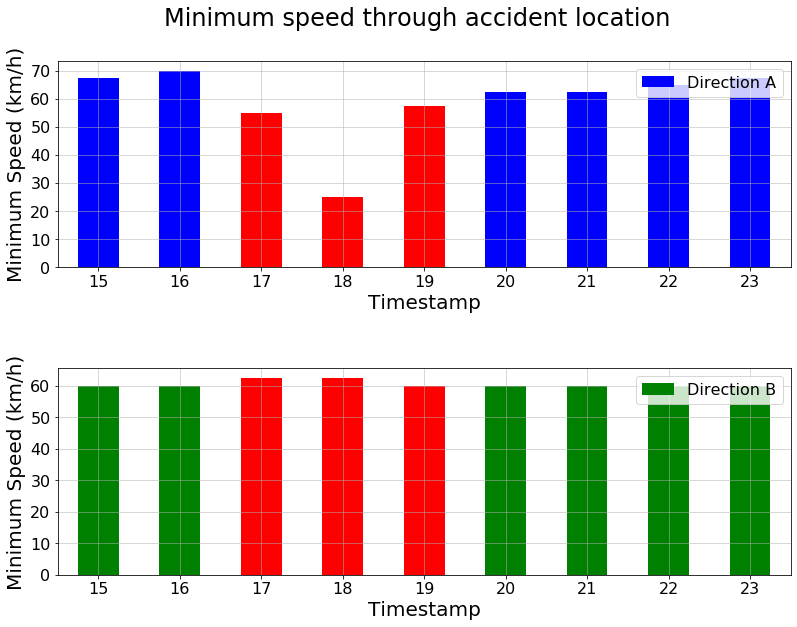

In [59]:
fig, axes = plt.subplots(nrows=2, ncols=1,figsize=(12,9))
fig.suptitle('Minimum speed through accident location', fontsize=24)
plt.tight_layout(pad=5, w_pad=5, h_pad=8,rect=[0, 0, 1, 0.98])
speedbandsnearaccidentagg.query("linkid=='103103050'").plot.bar("hour","minimumspeed",ax=axes[0],legend=True,label="Direction A",color=['blue','blue','red','red','red','blue','blue','blue','blue'])
speedbandsnearaccidentagg.query("linkid=='103103047'").plot.bar("hour","minimumspeed",ax=axes[1],legend=True,label="Direction B",color=['green','green','red','red','red','green','green','green','green'])
for n in [0,1]:
    axes[n].set_ylabel("Minimum Speed (km/h)",fontsize=20)
    axes[n].set_xlabel("Timestamp",fontsize=20)
    axes[n].grid(linestyle='-', linewidth='0.5')
    axes[n].legend(fontsize=16,loc='upper right')
    plt.setp(axes[n].get_xticklabels(),fontsize=16,rotation=0)
    plt.setp(axes[n].get_yticklabels(),fontsize=16,rotation=0)
plt.show()
plt.close()

# Summary

We have explored a few example queries you can run using Python and Jupyter Notebooks with GeoSpock DB Discovery.

This is by no means an exhaustive list of the types of analysis you can do – please continue your Discovery journey by trying out new queries, using our examples for inspiration. You never know when the investigator will be back with more questions about that taxi…